In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy import signal
from tqdm import tqdm
import numpy as np
import random
import pickle
import cv2
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

EPOCH = 100
KERNEL_SIZE = 3
BATCH_SIZE = 200
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

DATA_PATH = "./mit_data/"
SAVE_PATH = "./graph_data/"

In [2]:
parents_path = SAVE_PATH
child_path = os.listdir(parents_path)

temp_converted_img = list()
temp_ann_list = list()
converted_img = list()
X = (list())
y = (list())

for pic_path in (child_path):
    current_path = os.listdir(parents_path + pic_path)
    print("[INFO] Current path : " + parents_path + pic_path)
    for file_name in tqdm(current_path):
        path_for_array = parents_path + pic_path + "/" + file_name
        
        img = cv2.imread(path_for_array)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resize = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_AREA)
        temp_converted_img.append(img_resize / 255.0)
        
        check_ann = pic_path
                
        if check_ann == "N":            # Normal
            temp_ann_list.append([1, 0, 0, 0, 0])
        
        elif check_ann == "S":          # Supra-ventricular
            temp_ann_list.append([0, 1, 0, 0, 0])
        
        elif check_ann == "V":          # Ventricular
            temp_ann_list.append([0, 0, 1, 0, 0])
        
        elif check_ann == "F":          # False alarm
            temp_ann_list.append([0, 0, 0, 1, 0])
        
        else:                           # Unclassed 
            temp_ann_list.append([0, 0, 0, 0, 1])
    
    y.append(temp_ann_list)

[INFO] Current path : ./graph_data/F


100%|██████████| 803/803 [00:00<00:00, 1036.32it/s]


[INFO] Current path : ./graph_data/N


100%|██████████| 90631/90631 [01:30<00:00, 998.35it/s] 


[INFO] Current path : ./graph_data/Q


100%|██████████| 11148/11148 [00:11<00:00, 950.48it/s]


[INFO] Current path : ./graph_data/S


100%|██████████| 2781/2781 [00:02<00:00, 940.34it/s]


[INFO] Current path : ./graph_data/V


100%|██████████| 7236/7236 [00:07<00:00, 938.98it/s]


In [3]:
# 경로에 폴더가 없으면 폴더 만들기
def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [4]:
onehot_y = np.array(temp_ann_list)
temp_converted_img = np.array(temp_converted_img)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(temp_converted_img, onehot_y, test_size=0.33, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42, shuffle=True)

print("[SIZE]\t\tNpX lenght : {}\n\t\tNpY length : {}".format(X_train.shape, y_train.shape))
print("[SIZE]\t\tX_validation length : {}\n\t\ty_validation length : {}".format(X_val.shape, y_val.shape))
print("[SIZE]\t\tX_test length : {}\n\t\ty_test length : {}".format(X_test.shape, y_test.shape))

[SIZE]		NpX lenght : (75441, 64, 64, 3)
		NpY length : (75441, 5)
[SIZE]		X_validation length : (12263, 64, 64, 3)
		y_validation length : (12263, 5)
[SIZE]		X_test length : (24895, 64, 64, 3)
		y_test length : (24895, 5)


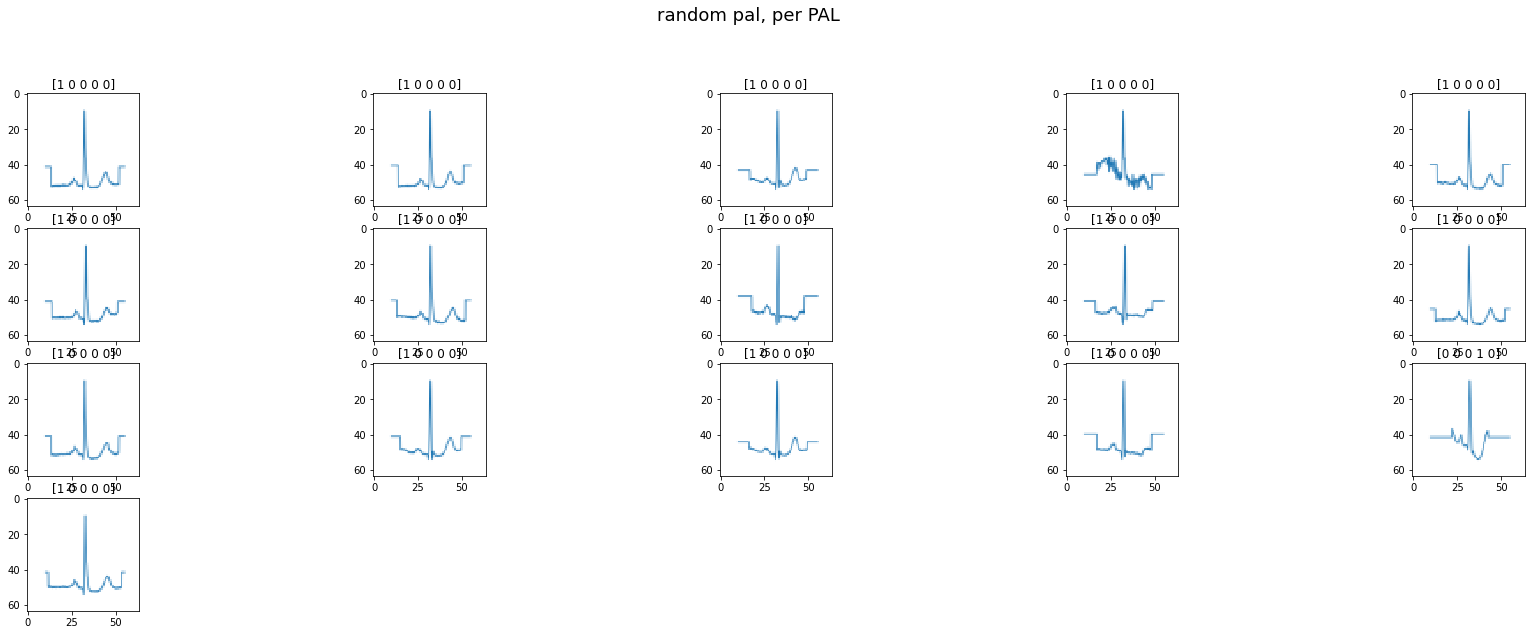

In [6]:
# 랜덤으로 뽑아서 뿌려보기

import matplotlib.pyplot as plt
import random
%matplotlib inline

plt.figure(figsize=(30, 12))
plt.suptitle("random pal, per PAL", fontsize=18)
n = 0
random.seed(11)
for i in random.sample(range(6480), 16):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(temp_converted_img[i], interpolation='nearest')
    ax.set_title(str(onehot_y[i]))
    n+=1

In [7]:
input_size = (64, 64, 3)

models = keras.Sequential([
    layers.Conv2D(8, kernel_size=(4, 4), activation='relu', input_shape=input_size),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Conv2D(13, kernel_size=(2, 2), activation='relu', input_shape=input_size),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Conv2D(13, kernel_size=(2, 2), activation='relu', input_shape=input_size),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [8]:
models.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 8)         392       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 13)        429       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 13)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 13)        689       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 13)         0

In [9]:
models.compile(
        optimizer='adam',
        # loss="sparse_categorical_crossentropy",
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

In [10]:
# 콜백 설정
outDir = './cheakpoint/raw_signal/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{val_accuracy:.4f}.h5'

def get_callbacks(patience = 50):
    # with tf.device('/device:GPU:0'):
        earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=patience)
        model_checkpoint = ModelCheckpoint(model_names, monitor='val_accuracy', verbose=1, save_best_only=True, period = 1)

        callbacks = [model_checkpoint]
        return callbacks

In [11]:
from tensorflow.python.client import device_lib 
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     # with tf.device('/device:GPU:0'):
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2376177228210930559
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5443503718
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15776794707584625657
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:02:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [12]:
# # 그래픽 카드 둘로 쓰기 (두개 있을때, 하나만 있다면 0)
# # gpu idx 를 0 또는 1 로 설정하시오
# import tensorflow as tf 
# import os

# os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" # gpu idx

# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)


In [13]:
callbacks = get_callbacks()
# strategy = tf.distribute.MirroredStrategy()
# tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

models_hist = models.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks = [callbacks]
)

Epoch 1/100
378/378 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.8488
Epoch 1: val_accuracy improved from -inf to 0.92832, saving model to ./cheakpoint/raw_signal\weights-0.9283.h5
378/378 [==============================] - 10s 15ms/step - loss: 0.4993 - accuracy: 0.8488 - val_loss: 0.2365 - val_accuracy: 0.9283
Epoch 2/100
376/378 [============================>.] - ETA: 0s - loss: 0.2332 - accuracy: 0.9307
Epoch 2: val_accuracy improved from 0.92832 to 0.95442, saving model to ./cheakpoint/raw_signal\weights-0.9544.h5
378/378 [==============================] - 5s 12ms/step - loss: 0.2331 - accuracy: 0.9307 - val_loss: 0.1490 - val_accuracy: 0.9544
Epoch 3/100
376/378 [============================>.] - ETA: 0s - loss: 0.1741 - accuracy: 0.9471
Epoch 3: val_accuracy improved from 0.95442 to 0.95972, saving model to ./cheakpoint/raw_signal\weights-0.9597.h5
378/378 [==============================] - 5s 12ms/step - loss: 0.1739 - accuracy: 0.9472 - val_loss: 0.1

# 결과 시각화 하기

In [14]:
# 학습 된 모델의 학습 과정 시각화
def plot_model__hist(hist):
    path = './cheakpoint/lefms/' # loss, accuracy 그래프 저장할 path
    createDirectory(path)

    # loss 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend()
    plt.show()

    # accuracy 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend(loc = "lower right")
    plt.show()

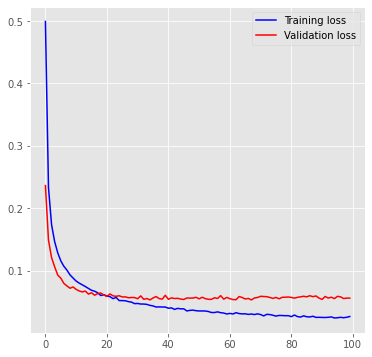

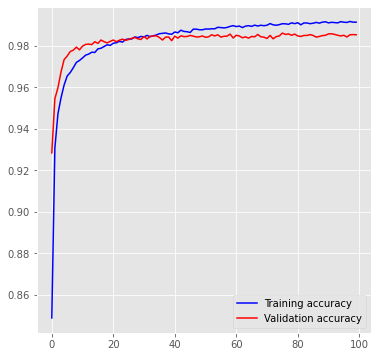

778/778 - 3s - loss: 0.0578 - accuracy: 0.9850 - 3s/epoch - 4ms/step
multi_model의 정확도: 98.50%
multi_model의 Loss: 0.05778013914823532


In [16]:
plot_model__hist(models_hist)
loss, acc = models.evaluate(X_test, y_test, verbose=2)
print("multi_model의 정확도: {:5.2f}%".format(100*acc))
print("multi_model의 Loss: {}".format(loss))

# 모델 불러와서 confusion matrix 그리기

In [17]:
tf.keras.backend.clear_session()

In [18]:
# 모델 불러오기
reconstructed_model = keras.models.load_model("./cheakpoint/raw_signal/weights-0.9861.h5")

In [19]:
# 예측값 얻기
y_pred = reconstructed_model.predict(X_test)

778/778 [==============================] - 2s 3ms/step


In [20]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y= []
for val in y_test:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y.append(cnt)

In [21]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y_pred = []
for val in y_pred:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y_pred.append(cnt)

In [22]:
# 최종 정확도 산출
score = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print('정답률 = ', score[1],'loss=', score[0])

778/778 [==============================] - 5s 6ms/step - loss: 0.0570 - accuracy: 0.9852
정답률 =  0.9852179288864136 loss= 0.056981753557920456


In [23]:
import seaborn

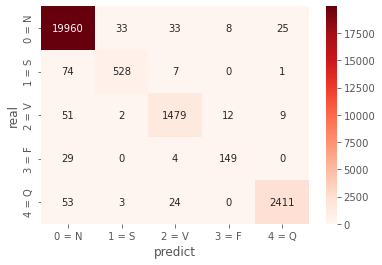

In [24]:
# 개수 버전
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

cm2 = confusion_matrix(new_y, new_y_pred)
sns.heatmap(cm2, annot = True, fmt = 'd', cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

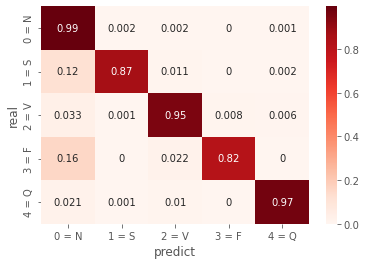

In [25]:
# percentile 버전
total = np.sum(cm2, axis=1)
cm2_percentile = cm2/total[:,None]
sns.heatmap(np.round(cm2_percentile,3), annot = True, cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(new_y, new_y_pred)

array([[19960,    33,    33,     8,    25],
       [   74,   528,     7,     0,     1],
       [   51,     2,  1479,    12,     9],
       [   29,     0,     4,   149,     0],
       [   53,     3,    24,     0,  2411]], dtype=int64)

In [27]:
# classification_report 그리기
from sklearn.metrics import classification_report
target_names = ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q']
print(classification_report(new_y, new_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       0 = N       0.99      1.00      0.99     20059
       1 = S       0.93      0.87      0.90       610
       2 = V       0.96      0.95      0.95      1553
       3 = F       0.88      0.82      0.85       182
       4 = Q       0.99      0.97      0.98      2491

    accuracy                           0.99     24895
   macro avg       0.95      0.92      0.93     24895
weighted avg       0.99      0.99      0.99     24895

